In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import pickle
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.2.0
sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)
matplotlib 2.1.2
numpy 1.19.1
pandas 0.22.0
sklearn 0.19.1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
# 从本地保存数据文件加载数据
with open(file='data/california_housing.pkl', mode='rb') as f:
    housing=pickle.load(f)
# from sklearn.datasets import fetch_california_housing
# housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# 此处采用fit_transform是因为，该函数可以将训练集的均值和方差记录下来，这样在验证集和测试集可以保持一致，这样也就保证了数据是同分布的，模型的构建和训练才会有效
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [27]:
# 子类API
class WideDeepModel(keras.models.Model):
    def __init__(self):
        super(WideDeepModel, self).__init__()
        """定义模型的层次"""
        self.hidden1_layer = keras.layers.Dense(30, activation='relu')
        self.hidden2_layer = keras.layers.Dense(30, activation='relu')
        self.output_layer = keras.layers.Dense(1)
        
    def call(self, input):
        hidden1 = self.hidden1_layer(input)
        hidden2 = self.hidden2_layer(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_layer(concat)
        return output
    
# model = WideDeepModel()
# 另外一种实现方式
model = keras.models.Sequential([WideDeepModel(),])

model.build(input_shape=(None, 8))
model.summary()
model.compile(loss="mean_squared_error", optimizer="sgd")
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
wide_deep_model_6 (WideDeepM multiple                  1239      
Total params: 1,239
Trainable params: 1,239
Non-trainable params: 0
_________________________________________________________________


In [28]:
# 训练的时候发现batch_size过小，会导致模型不拟合,batch_size对模型训练的影响：https://zhuanlan.zhihu.com/p/86827387
# 重点分析一下batch_size的影响
history = model.fit(x_train_scaled, y_train,
                    batch_size = 128,
                    validation_data = (x_valid_scaled, y_valid),
                    epochs = 100,
                    callbacks = callbacks)

Epoch 1/100
91/91 [==============================] - 0s 4ms/step - loss: 1.3012 - val_loss: 0.8776
Epoch 2/100
91/91 [==============================] - 0s 4ms/step - loss: 0.9605 - val_loss: 0.6767
Epoch 3/100
91/91 [==============================] - 0s 4ms/step - loss: 0.5970 - val_loss: 0.6137
Epoch 4/100
91/91 [==============================] - 0s 4ms/step - loss: 0.5406 - val_loss: 0.5667
Epoch 5/100
91/91 [==============================] - 0s 4ms/step - loss: 0.5074 - val_loss: 0.5387
Epoch 6/100
91/91 [==============================] - 0s 4ms/step - loss: 0.4832 - val_loss: 0.5112
Epoch 7/100
91/91 [==============================] - 0s 4ms/step - loss: 0.4702 - val_loss: 0.4937
Epoch 8/100
91/91 [==============================] - 0s 4ms/step - loss: 0.4554 - val_loss: 0.4792
Epoch 9/100
91/91 [==============================] - 0s 4ms/step - loss: 0.4464 - val_loss: 0.4702
Epoch 10/100
91/91 [==============================] - 0s 4ms/step - loss: 0.4423 - val_loss: 0.4643
Epoch 11/

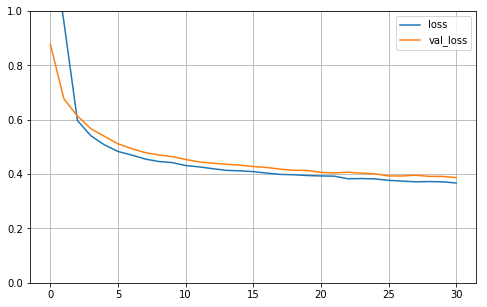

In [29]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [30]:
model.evaluate(x_test_scaled, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.3847


0.38471126556396484